# ResNet50 Model

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import pickle
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import os
import cv2

In [13]:
x_train = pickle.load(open("x_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))

In [14]:
x_train = x_train/255.0
x_train.shape

(12000, 64, 64, 3)

In [15]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters= F2 , kernel_size=(f,f) , strides=(1,1), padding='same' , name= conv_name_base + "2b" , kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3 , name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3 , kernel_size=(1,1) , strides=(1,1) , padding='valid', name= conv_name_base +'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3 , name = bn_name_base + '2c')(X)

    # Final step: Adding shortcut value to main path, and pass it through a RELU activation
    X = Add()([X , X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.94823   -0.         1.1610144  2.747859  -0.         1.36677  ]


In [17]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2 , (f,f) , strides=(1,1) , name= conv_name_base +'2b' ,padding='same', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3 , name=bn_name_base +'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3 , (1,1) , strides=(1,1) , name= conv_name_base +'2c' , padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3 , name= bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1,1), strides=(s,s) , name= conv_name_base +'1' ,padding ='valid' , kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3 , name=bn_name_base +'1')(X_shortcut)

    # Final step: Adding shortcut value to main path, and passing it through a RELU activation
    X = Add()([X , X_shortcut])
    X = Activation('relu')(X)

    return X

In [18]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.09018463  1.2348979   0.46822023  0.03671761 -0.          0.65516603]


In [19]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2,2) , strides=None , name= 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [24]:
img_size = 64
model = ResNet50(input_shape = (img_size, img_size, 3), classes = 4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
XTraining, XValidation, YTraining, YValidation = train_test_split(x_train, y_train, stratify=y_train,test_size=0.15)
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=5, min_delta = 0.02)

In [26]:
print(x_train.shape)
print(y_train.shape)
print(XTraining.shape)
print(YTraining.shape)
print(XValidation.shape)
print(YValidation.shape)

(12000, 64, 64, 3)
(12000, 4)
(10200, 64, 64, 3)
(10200, 4)
(1800, 64, 64, 3)
(1800, 4)


In [27]:
history = model.fit(XTraining, YTraining, epochs = 20, validation_data=(XValidation,YValidation), 
                    batch_size=32, callbacks=[monitor_val_acc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10200 samples, validate on 1800 samples
Epoch 1/20
10200/10200 [==============================] - 536s 53ms/step - loss: 0.5591 - acc: 0.8044 - val_loss: 0.1291 - val_acc: 0.9583
Epoch 2/20
10200/10200 [==============================] - 527s 52ms/step - loss: 0.0773 - acc: 0.9749 - val_loss: 0.0764 - val_acc: 0.9783
Epoch 3/20
10200/10200 [==============================] - 537s 53ms/step - loss: 0.0781 - acc: 0.9766 - val_loss: 0.0281 - val_acc: 0.9900
Epoch 4/20
10200/10200 [==============================] - 544s 53ms/step - loss: 0.0285 - acc: 0.9919 - val_loss: 2.1429 - val_acc: 0.6478
Epoch 5/20
10200/10200 [==============================] - 527s 52ms/step - loss: 0.0210 - acc: 0.9945 - val_loss: 0.0028 - val_acc: 0.9978
Epoch 6/20
10200/10200 [==============================] - 539s 53ms/step - loss: 0.0133 - acc: 0.9964 - val_loss: 0.0539 - val_acc: 0.9878
Epoch 7/20
10200/10200 

In [91]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Evaluating the Model

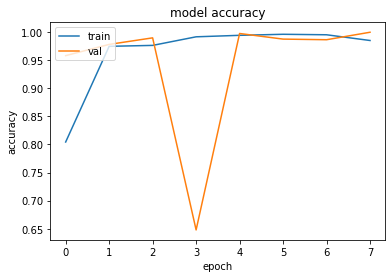

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
DataDir_Test = "E:/asl_alphabet_test"

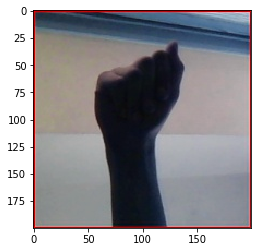

In [40]:
Categories = ["A", "B", "C", "D"]
for category in Categories:
    path = os.path.join(DataDir_Test, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        break
    break

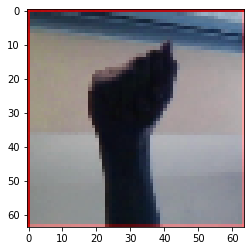

In [41]:
img_size = 64
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(new_array)
plt.show()

In [42]:
test_data = []
def create_test_data():
    for category in Categories:
        path = os.path.join(DataDir_Test, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            test_data.append([new_array, class_num])
create_test_data()

In [43]:
print(len(test_data))

1200


In [44]:
x_test = []
y_test = []

for features, labels in test_data:
    x_test.append(features)
    y_test.append(labels)

In [45]:
x_test = np.asarray(x_test)
x_test = np.array(x_test).reshape(x_test.shape[0], img_size, img_size, 3)
print(x_test.shape)
y_test = np.array(y_test).reshape(-1, 1)
from keras.utils import np_utils

# One-hot encode the training labels
y_test = np_utils.to_categorical(y_test)
print(y_test.shape)

(1200, 64, 64, 3)
(1200, 4)


In [46]:
x_test = x_test/255.0

In [47]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1200/1200 [==============================] - 17s 14ms/step
Loss = 0.12883542330168135
Test Accuracy = 0.9916666666666667


# Check for Custom Images

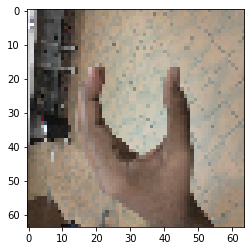

In [82]:
img_path = "E:/own image data/mydata1.jpg"
img = image.load_img(img_path, target_size=(64, 64))
plt.imshow(img)

In [85]:
data = np.asarray(img)
data = np.expand_dims(data, axis=0)
data.shape

(1, 64, 64, 3)

In [90]:
print("class prediction vector [p(A), p(B), p(C), p(D)] = ", model.predict(data))

class prediction vector [p(A), p(B), p(C), p(D)] =  [[0. 0. 1. 0.]]


### So, the model is working well for our custom data